In [1]:
%matplotlib inline

import re
from collections import Counter
from tqdm import tqdm
# from fuzzywuzzy import fuzz
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
import multiprocessing
import spacy
from spacy.matcher import PhraseMatcher
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab)

In [2]:
def collect_establishments(data_dir='../data/hotel/500k/', splits='train test valid'):
    estabs = Counter()

    for split in splits.split():
        estab_file = Path(data_dir) / f'{split}.establishment'
        print(estab_file)
        with open(estab_file, 'r', encoding='utf8') as f:
            for line in f:
                estabs[line.strip()] += 1

    print(len(estabs))
    print(estabs.most_common(10))
    return estabs

terms = collect_establishments()
patterns = [nlp.make_doc(text) for text in terms]
matcher.add("Establishments", patterns)


/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/train.establishment
/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/test.establishment
/srv/scratch6/kew/bart/hospo_respo/en/data/hotel/500k/valid.establishment
7593
[('The Palazzo at The Venetian', 3018), ('Sofitel London Heathrow', 2779), ('The Hotel Windsor', 2293), ('Meriton Suites Herschel Street, Brisbane', 1756), ('Meriton Suites Kent Street, Sydney', 1728), ('Fairmont Banff Springs', 1705), ('InterContinental London - The O2', 1237), ('The Shankly Hotel', 1230), ('Rydges Sydney Airport Hotel', 1190), ('Clontarf Castle Hotel', 1189)]


In [3]:
review = """Simply wow and excellent customer service! ---SEP--- Our experience with this hotel was simply amazing that the subsequent hotels we've stayed in during our holiday in the US pale in comparison. We would have gone for the usual brand, but good that we tried The Langham. 1. Check-in - Fast and efficient. Very friendly and accommodating staff, from the doorman, reception and concierge. Their friendliness was not pretentious. You can feel a certain genuiness. Maybe in general people from Chicago are like this? The concierge was very helpful in providing us tips on where to go. We wanted to try a jazz bar and he was patiently explaining to us the options. And if you like to shop, the hotel provides map to the Magnificent Mile. 2. Room tip and amenities - we got what we requested for - higher floor with nice view of the river. The ceiling to floor window gave a good view. The bathroom/toilet was very nice. The bed was comfortable... really relaxing after coming back from a long tiring day. 3. Food - It was very pleasant to have breakfast in the Travelle restaurant. Both food and service were excellent. 4. Amenities - not able to comment as we didn't have time to make use of these. 5. Location - hotel location was good due to the stunning view and accessibility to good restaurants and shopping areas. 6. Check-out was fast and efficient. Our luggages were taken care of immediately. They gladly assisted us also in checking-in for our domestic flight. We like our over-all experience in Chicago and will definitely stay in Langham. We're planning to try also this hotel in other locations."""
response = """Thank you very much for choosing The Langham, for your recommendation, and for sharing so many details from your stay. I'm delighted that you were able to enjoy Travelle as well, and to make the most of our Concierge services. All the best to you, and we look forward to welcoming you back. All the best, Bob Robert Schofield Managing Director The Langham, Chicago"""

def compute_ent_overlap(review_response_pair, valid_ents=['GPE', 'LOC', 'PERSON', 'FAC', 'ORG', 'PRODUCT']):
    review, response = nlp.pipe(review_response_pair)
    rev_ents = set(ent.text for ent in review.ents if ent.label_ in valid_ents)
    resp_ents = set(ent.text for ent in response.ents if ent.label_ in valid_ents)    
    return len(resp_ents - rev_ents)

# matches = matcher(review)
# for match_id, start, end in matches:
#     span = doc[start:end]
#     print(span.text)

def check_reno_mentions(response_file):
    
    reno_counts = []
    with open(response_file, 'r', encoding='utf8') as rfile:
        for resp in rfile:
            resp = resp.strip().lower()
                
            if re.search('renovat', resp):
                reno_counts.append(1)
            else:
                reno_counts.append(0)

    print(sum(reno_counts))                       
    return reno_counts

def check_refurb_mentions(response_file):
    
    reno_counts = []
    with open(response_file, 'r', encoding='utf8') as rfile:
        for resp in rfile:
            resp = resp.strip().lower()
                
            if re.search('refurbish', resp):
                reno_counts.append(1)
            else:
                reno_counts.append(0)

    print(sum(reno_counts))                       
    return reno_counts


def process_texts(texts, n_cores=12):
    """parallel processing"""
    pool = multiprocessing.Pool(n_cores)
    result = pool.map(compute_ent_overlap, texts)
    pool.close()
    pool.join()
    return result

In [4]:
# # testing
# text = "Apple was founded by Steve Jobs in Hotel Belvedere in California to build the best Computers"
# doc = nlp(text)
# for ent in doc.ents:
#     print(ent, ent.label_)

In [5]:
review_file = '../data/hotel/500k/test.review'
response_file = '../data/hotel/500k/test.response'
hallu_counts_csv = '../data/analysis/hallu_checker-NER.csv'

data = {}

if not Path(hallu_counts_csv).exists():
    with open(review_file, 'r', encoding='utf8') as rev_file, open(response_file, 'r', encoding='utf8') as resp_file:
        texts = []
        for review, response in tqdm(zip(rev_file, resp_file)):
            texts.append((review, response))

        data['ground_truth'] = process_texts(texts)

    for model in ['baseline', 'filt_freq_distro', 'filt_gen_sent', 'filt_tgt_ppl']:
        model_occurrence_freqs = []
        for seed in ['', '_s42', '_s985']:
            seed_occurrence_freqs = []
            texts = []
            response_file = Path(f'../models/{model+seed}/inference/bs5.txt')
            if not response_file.exists():
                response_file = f'../models/{model+seed}/inference/ckpt07/bs5.txt'

            with open(review_file, 'r', encoding='utf8') as rev_file, open(response_file, 'r', encoding='utf8') as resp_file:
                for review, response in tqdm(zip(rev_file, resp_file)):
                    texts.append((review, response))

            data[model+seed] = process_texts(texts)

    df = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
    df.to_csv(hallu_counts_csv)
else:
    df = pd.read_csv(hallu_counts_csv, header=0, index_col=0)

print(df.columns)
df

Index(['ground_truth', 'baseline', 'baseline_s42', 'baseline_s985',
       'filt_freq_distro', 'filt_freq_distro_s42', 'filt_freq_distro_s985',
       'filt_gen_sent', 'filt_gen_sent_s42', 'filt_gen_sent_s985',
       'filt_tgt_ppl', 'filt_tgt_ppl_s42', 'filt_tgt_ppl_s985'],
      dtype='object')


,ground_truth,baseline,baseline_s42,baseline_s985,filt_freq_distro,filt_freq_distro_s42,filt_freq_distro_s985,filt_gen_sent,filt_gen_sent_s42,filt_gen_sent_s985,filt_tgt_ppl,filt_tgt_ppl_s42,filt_tgt_ppl_s985
0,2,0,0,0,0,1,1,1,2,2,0,0,0
1,2,0,1,0,2,1,1,1,1,1,1,2,1
2,4,4,3,3,0,0,0,3,3,4,0,0,0
3,1,2,2,2,2,2,2,2,2,2,2,2,2
4,5,2,0,0,1,1,0,2,2,2,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24731,2,2,2,2,6,3,4,3,2,3,2,2,2
24732,2,0,0,0,5,3,2,2,3,2,1,1,4
24733,1,0,3,1,1,3,2,1,1,2,2,2,1
24734,4,1,1,2,6,5,6,2,2,2,3,3,2


In [6]:
df['baseline'] = (df['baseline'] + df['baseline_s42'] + df['baseline_s985']) / 3
df['filt_freq_distro'] = (df['filt_freq_distro'] + df['filt_freq_distro_s42'] + df['filt_freq_distro_s985']) / 3
df['filt_gen_sent'] = (df['filt_gen_sent'] + df['filt_gen_sent_s42'] + df['filt_gen_sent_s985']) / 3
df['filt_tgt_ppl'] = (df['filt_tgt_ppl'] + df['filt_tgt_ppl_s42'] + df['filt_tgt_ppl_s985']) / 3
df.drop(columns=[
    'baseline_s42', 'baseline_s985', 'filt_freq_distro_s42', 'filt_freq_distro_s985',
    'filt_gen_sent_s42', 'filt_gen_sent_s985', 'filt_tgt_ppl_s42', 'filt_tgt_ppl_s985'
], inplace=True)
print(df.columns)
df      
        
        

Index(['ground_truth', 'baseline', 'filt_freq_distro', 'filt_gen_sent',
       'filt_tgt_ppl'],
      dtype='object')


,ground_truth,baseline,filt_freq_distro,filt_gen_sent,filt_tgt_ppl
0,2,0.000000,0.666667,1.666667,0.000000
1,2,0.333333,1.333333,1.000000,1.333333
2,4,3.333333,0.000000,3.333333,0.000000
3,1,2.000000,2.000000,2.000000,2.000000
4,5,0.666667,0.666667,2.000000,1.000000
...,...,...,...,...,...
24731,2,2.000000,4.333333,2.666667,2.000000
24732,2,0.000000,3.333333,2.333333,2.000000
24733,1,1.333333,2.000000,1.333333,1.666667
24734,4,1.333333,5.666667,2.000000,2.666667


In [7]:
cm = sns.color_palette("colorblind")
print(cm)
cm.insert(0, cm[-3])

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


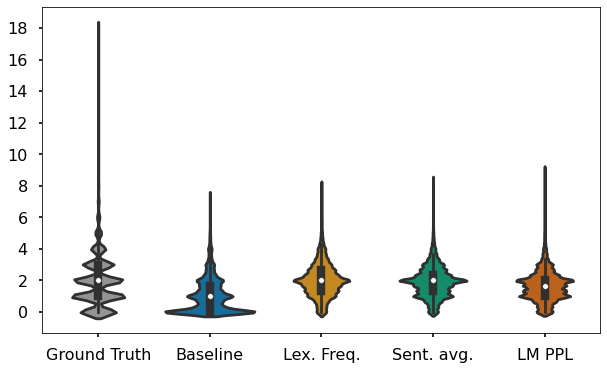

In [49]:
with plt.style.context('seaborn-poster'):

    fig, ax = plt.subplots(1,1, figsize=(10,6))

    sns.violinplot(data=df, ax=ax, palette=cm)
    ax.set_yticks(np.arange(0, 20, 2), minor=False)
    ax.set_xticks(np.arange(0, 5))
    ax.set_xticklabels(['Ground Truth', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL'])
    
#     for patch in ax.artists:
#         r, g, b, a = patch.get_facecolor()
#         patch.set_facecolor((r, g, b, .6))

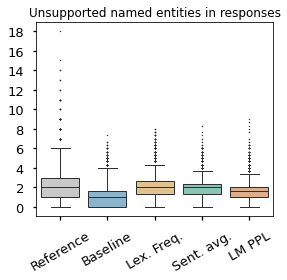

In [50]:
# plt.style.use('tableau-colorblind10')

with plt.style.context('seaborn-talk'):

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    sns.boxplot(data=df, ax=ax, palette=cm, saturation=0.75, linewidth=1, fliersize=0.5)
    ax.set_yticks(np.arange(0, 20, 2), minor=False)
    ax.set_xticks(np.arange(0, 5))
    ax.set_xticklabels(['Reference', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL'], rotation=30, ha='center')
    
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))


# plt.xticks()    
    
ax.set_title("Unsupported named entities in responses")
plt.tight_layout()
plt.savefig('./plots/hallu_check_ner.png', dpi=300, format='png') 

In [10]:
refurb_counts = {}

refurb_counts['ground_truth'] = check_refurb_mentions('../data/hotel/500k/test.response')

for model in ['baseline', 'filt_freq_distro', 'filt_gen_sent', 'filt_tgt_ppl']:
    occurrence_freqs = []
    for seed in ['', '_s42', '_s985']:
        try:
            responses = f'../models/{model+seed}/inference/bs5.txt'
            refurb_counts[model+seed] = check_refurb_mentions(responses)
        except:
            responses = f'../models/{model+seed}/inference/ckpt07/bs5.txt'
            refurb_counts[model+seed] = check_refurb_mentions(responses)

refurb_df = pd.DataFrame.from_dict(refurb_counts, orient='columns', dtype=None, columns=None)
print(refurb_df.columns)

refurb_df['baseline'] = (refurb_df['baseline'] + refurb_df['baseline_s42'] + refurb_df['baseline_s985']) / 3
refurb_df['filt_freq_distro'] = (refurb_df['filt_freq_distro'] + refurb_df['filt_freq_distro_s42'] + refurb_df['filt_freq_distro_s985']) / 3
refurb_df['filt_gen_sent'] = (refurb_df['filt_gen_sent'] + refurb_df['filt_gen_sent_s42'] + refurb_df['filt_gen_sent_s985']) / 3
refurb_df['filt_tgt_ppl'] = (refurb_df['filt_tgt_ppl'] + refurb_df['filt_tgt_ppl_s42'] + refurb_df['filt_tgt_ppl_s985']) / 3
refurb_df.drop(columns=[
    'baseline_s42', 'baseline_s985', 'filt_freq_distro_s42', 'filt_freq_distro_s985',
    'filt_gen_sent_s42', 'filt_gen_sent_s985', 'filt_tgt_ppl_s42', 'filt_tgt_ppl_s985'
], inplace=True)
print(refurb_df.columns)
# refurb_df 

refurb_df = refurb_df.sum()
print(type(refurb_df))
refurb_df

379
327
240
213
722
804
659
683
727
588
647
774
613
Index(['ground_truth', 'baseline', 'baseline_s42', 'baseline_s985',
       'filt_freq_distro', 'filt_freq_distro_s42', 'filt_freq_distro_s985',
       'filt_gen_sent', 'filt_gen_sent_s42', 'filt_gen_sent_s985',
       'filt_tgt_ppl', 'filt_tgt_ppl_s42', 'filt_tgt_ppl_s985'],
      dtype='object')
Index(['ground_truth', 'baseline', 'filt_freq_distro', 'filt_gen_sent',
       'filt_tgt_ppl'],
      dtype='object')
<class 'pandas.core.series.Series'>


ground_truth        379.000000
baseline            260.000000
filt_freq_distro    728.333333
filt_gen_sent       666.000000
filt_tgt_ppl        678.000000
dtype: float64

In [11]:
reno_counts = {}

reno_counts['ground_truth'] = check_reno_mentions('../data/hotel/500k/test.response')

for model in ['baseline', 'filt_freq_distro', 'filt_gen_sent', 'filt_tgt_ppl']:
    occurrence_freqs = []
    for seed in ['', '_s42', '_s985']:
        try:
            responses = f'../models/{model+seed}/inference/bs5.txt'
            reno_counts[model+seed] = check_reno_mentions(responses)
        except:
            responses = f'../models/{model+seed}/inference/ckpt07/bs5.txt'
            reno_counts[model+seed] = check_reno_mentions(responses)

reno_df = pd.DataFrame.from_dict(reno_counts, orient='columns', dtype=None, columns=None)
print(reno_df.columns)
# reno_df

reno_df['baseline'] = (reno_df['baseline'] + reno_df['baseline_s42'] + reno_df['baseline_s985']) / 3
reno_df['filt_freq_distro'] = (reno_df['filt_freq_distro'] + reno_df['filt_freq_distro_s42'] + reno_df['filt_freq_distro_s985']) / 3
reno_df['filt_gen_sent'] = (reno_df['filt_gen_sent'] + reno_df['filt_gen_sent_s42'] + reno_df['filt_gen_sent_s985']) / 3
reno_df['filt_tgt_ppl'] = (reno_df['filt_tgt_ppl'] + reno_df['filt_tgt_ppl_s42'] + reno_df['filt_tgt_ppl_s985']) / 3
reno_df.drop(columns=[
    'baseline_s42', 'baseline_s985', 'filt_freq_distro_s42', 'filt_freq_distro_s985',
    'filt_gen_sent_s42', 'filt_gen_sent_s985', 'filt_tgt_ppl_s42', 'filt_tgt_ppl_s985'
], inplace=True)
print(reno_df.columns)
# reno_df 

reno_df = reno_df.sum()
print(type(reno_df))



503
188
136
137
197
595
179
810
954
783
344
360
297
Index(['ground_truth', 'baseline', 'baseline_s42', 'baseline_s985',
       'filt_freq_distro', 'filt_freq_distro_s42', 'filt_freq_distro_s985',
       'filt_gen_sent', 'filt_gen_sent_s42', 'filt_gen_sent_s985',
       'filt_tgt_ppl', 'filt_tgt_ppl_s42', 'filt_tgt_ppl_s985'],
      dtype='object')
Index(['ground_truth', 'baseline', 'filt_freq_distro', 'filt_gen_sent',
       'filt_tgt_ppl'],
      dtype='object')
<class 'pandas.core.series.Series'>


In [12]:
stem_df = pd.DataFrame(data=dict(renovat=reno_df, refurb=refurb_df))   
stem_df

,renovat,refurb
ground_truth,503.000000,379.000000
baseline,153.666667,260.000000
filt_freq_distro,323.666667,728.333333
filt_gen_sent,849.000000,666.000000
filt_tgt_ppl,333.666667,678.000000


In [13]:
stem_df.reset_index(inplace=True)
print(stem_df)

              index     renovat      refurb
0      ground_truth  503.000000  379.000000
1          baseline  153.666667  260.000000
2  filt_freq_distro  323.666667  728.333333
3     filt_gen_sent  849.000000  666.000000
4      filt_tgt_ppl  333.666667  678.000000


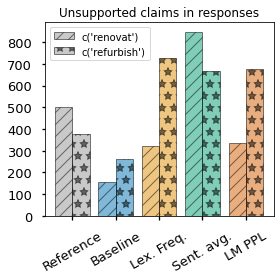

In [75]:
reno = np.array(stem_df['renovat'])
refurb = np.array(stem_df['refurb'])
index = np.array(stem_df['index'])
# index = ['Reference', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL']
shift=0.4
width=0.4
bot1=0
bot2=0
with plt.style.context('seaborn-talk'):
    x = np.arange(len(index))
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    plt.bar(x-(shift/2), reno, width, 
            label="c('renovat')", color=cm[:len(index)], hatch = '//', edgecolor='black', linewidth=1, alpha=0.5)
    plt.bar(x+(shift/2), refurb, width, bottom=bot1, 
            label="c('refurbish')", color=cm[:len(index)], hatch = '*', edgecolor='black', linewidth=1, alpha=0.5)
    
#     ax.set_xticklabels(['Reference', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL'], rotation=30, ha='center')
plt.xticks(ticks=x, labels=['Reference', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL'], rotation=30, ha='center')
leg = ax.legend()
ax.set_title("Unsupported claims in responses")
plt.tight_layout()
plt.savefig('./plots/hallu_check_renovation.png', dpi=300, format='png') 


In [53]:
# models = ['ground_truth','baseline','filt_freq_distro','filt_gen_sent', 'filt_tgt_ppl']
# models = ['Ref', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL']

stem_df_tidy = stem_df.melt(id_vars='index').rename(columns=str.title)
print(stem_df_tidy)


              Index Variable       Value
0      ground_truth  renovat  503.000000
1          baseline  renovat  153.666667
2  filt_freq_distro  renovat  323.666667
3     filt_gen_sent  renovat  849.000000
4      filt_tgt_ppl  renovat  333.666667
5      ground_truth   refurb  379.000000
6          baseline   refurb  260.000000
7  filt_freq_distro   refurb  728.333333
8     filt_gen_sent   refurb  666.000000
9      filt_tgt_ppl   refurb  678.000000


<class 'pandas.core.series.Series'>
503.000000     Reference
153.666667      Baseline
323.666667    Lex. Freq.
849.000000    Sent. avg.
333.666667        LM PPL
dtype: object


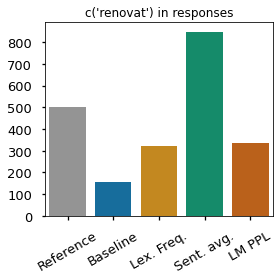

In [108]:
# models = ['ground_truth','baseline','filt_freq_distro','filt_gen_sent', 'filt_tgt_ppl']
models = ['Reference', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL']
occurrences = [503, 153.66666666666666, 323.66666666666663, 848.9999999999999, 333.66666666666663]

# sr = pd.Series(data=occurrences, index=models)
sr = pd.Series(data=models, index=occurrences)
print(type(sr))
print(sr)

with plt.style.context('seaborn-talk'):

    fig, ax = plt.subplots(1,1, figsize=(4,4))
    sns.barplot(x=sr.values, y=sr.index, ax=ax, palette=cm, saturation=0.75)
    ax.set_xticklabels(['Reference', 'Baseline', 'Lex. Freq.', 'Sent. avg.', 'LM PPL'], rotation=30, ha='center')
    
ax.set_title("c('renovat') in responses")
plt.tight_layout()
plt.savefig('./plots/hallu_check_renovation.png', dpi=300, format='png') 
            
            
            